# *VAE_gen_1*
# Génération de mélodies avec un VAE vanille vanillé

## Génération avec un autoencoder simple

J'ai récupéré le modèle d'autoencoder vanille pour mnist de Geeksforgeeks 

https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/

### Préparation des données

Dans ce notebook le pré-traitement des données est basique et pas très réfléchit. 
Il consiste à transformer les notes en une liste de nombre. Si la note est tenue, la durée est représenté par un ensemble de 1. De plus, les silence sont représetné avec des 0. 

La liste de nombre est ensuite normalisée et ramenée entre 0 et 1. Les modèles sont ensuite entrainées à partir de cette liste. 

Cela pose un problème lors du décodage. En effet, des notes très basses aparaissent. Cela est dû au faite que le modèle n'apprend pas que le 0.01 est une valeur spécifique correspondant à une note tenue. Pour régler ce problème, lors du décodage j'ai indiqué que toutes les notes en dessous de 0.5 sont des 0.1. Cela est problématique car ça ne respecte pas vraiment la logique de l'encodage. En revanche, cela est une bonne solution en attendant de trouver une meilleure solution d'encodage. 

Dans le notebook, VAE_gen_2 je propose une nouvelle version de l'encodage qui est plus adaptée à notre problématique. 

In [1]:
## Lecture des fichiers de musique

import os
import music21 as m21

def load_songs(data_path, max_songs_nb):
    songs = []
    for path, subdirs, files in os.walk(data_path):
        for file in files:
            if file[-3:] == "krn":
                #print(os.path.join(path, file))
                song = m21.converter.parse(os.path.join(path, file))
                songs.append(song)
                max_songs_nb -= 1
                if max_songs_nb == 0 : return songs
    return songs

DATASET_PATH = "data/han"

print("loading data...")
songs = load_songs(DATASET_PATH, 1000)
print("songs loaded")


loading data...
songs loaded


In [2]:
## Prétraitement des données

# Durée des notes
ACCEPTABLE_DURATIONS = [
    0.25, # 16th note
    0.5, # 8th note
    0.75,
    1.0, # quarter note
    1.5,
    2, # half note
    3,
    4 # whole note
]

# Vérification de la durée des notes et suppression des éléments non conformes
def has_acceptable_durations(song, acceptable_durations):
    for note in song.flatten().notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True

for song in songs:
    if not has_acceptable_durations(song, ACCEPTABLE_DURATIONS):
        # song.show()
        # song.show("midi")
        songs.remove(song)

# Transposition en do majeur
def transpose(song, print_enabled=False):
    # transpose song in Cmaj/Amin

    # get key signature
    parts = song.getElementsByClass(m21.stream.Part)
    measures_part0 = parts[0].getElementsByClass(m21.stream.Measure)
    key = measures_part0[0][4]
    if print_enabled : print("old key : ", key)

    # estimate key if not indicated
    if not isinstance(key, m21.key.Key):
        key = song.analyze("key")

    # get interval for transposition
    if key.mode == "major":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
    elif key.mode == "minor":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))
    
    transposed_song = song.transpose(interval)

    return transposed_song

transposed_songs = []
for song in songs:
    transposed_songs.append(transpose(song))

In [3]:
## Encodage des données

"""
- Chaque note est représentée par un entier
- La durée d'une note est représentée par des 1 qui la suive 
- Les silences sont représentées par l'entier 0
"""

def encode_song(song, time_step=0.25):
    encoded_song = []

    for event in song.flat.notesAndRests:
        if isinstance(event, m21.note.Note):
            symbol = event.pitch.midi
        elif isinstance(event, m21.note.Rest):
            symbol = 0

        steps = int(event.duration.quarterLength / time_step)
        for step in range(steps):
            if step == 0:
                encoded_song.append(symbol)
            else:
                encoded_song.append(1)

    return encoded_song

# Exemple
song = transposed_songs[0]
encoded_song = encode_song(song)
print(encoded_song)

## Création des séquences
encoded_songs = [encode_song(song) for song in transposed_songs]

/home/am/UQAC/AP/projet/projet-env/lib/python3.12/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


[69, 69, 1, 1, 72, 1, 69, 1, 67, 1, 64, 67, 69, 1, 0, 1, 74, 1, 74, 1, 72, 1, 69, 1, 67, 1, 64, 67, 69, 1, 0, 1, 69, 1, 69, 1, 72, 1, 67, 1, 69, 1, 0, 1, 74, 1, 74, 1, 72, 1, 67, 1, 69, 1, 0, 1, 69, 1, 69, 1, 72, 1, 69, 67, 64, 1, 0, 1, 74, 1, 74, 1, 72, 1, 69, 67, 64, 1, 0, 1, 76, 1, 76, 1, 74, 1, 76, 1, 72, 1, 1, 1, 79, 1, 76, 1, 74, 1, 1, 1, 72, 1, 69, 67, 69, 1, 0, 1, 72, 1, 1, 1, 69, 1, 69, 1, 67, 1, 64, 67, 69, 1, 0, 1, 72, 1, 69, 69, 67, 1, 64, 67, 69, 1, 1, 1]


In [4]:
## Padding 
# Toutes les données doivent avoir la même longueur
# On ajoute des 0 à la fin des séquences

# affiche la longueur maximale des séquences
max_length = max([len(song) for song in encoded_songs])
print("max length : ", max_length) 
mean_length = int(sum(map(len, encoded_songs)) / len(encoded_songs))
print("mean length : ", mean_length)

max length :  960
mean length :  168


In [20]:
# On fait des séquences de 256 éléments

def padding(song, sequence_length=128):
    if len(song) >= sequence_length:
        return song[:sequence_length]
    input_sequence = song.copy()
    for i in range(sequence_length - len(input_sequence)):
        input_sequence.append(0)
    return input_sequence

input_sequence = padding(encoded_songs[0])
print(input_sequence)

padded_songs = [padding(song) for song in encoded_songs]

[69, 69, 1, 1, 72, 1, 69, 1, 67, 1, 64, 67, 69, 1, 0, 1, 74, 1, 74, 1, 72, 1, 69, 1, 67, 1, 64, 67, 69, 1, 0, 1, 69, 1, 69, 1, 72, 1, 67, 1, 69, 1, 0, 1, 74, 1, 74, 1, 72, 1, 67, 1, 69, 1, 0, 1, 69, 1, 69, 1, 72, 1, 69, 67, 64, 1, 0, 1, 74, 1, 74, 1, 72, 1, 69, 67, 64, 1, 0, 1, 76, 1, 76, 1, 74, 1, 76, 1, 72, 1, 1, 1, 79, 1, 76, 1, 74, 1, 1, 1, 72, 1, 69, 67, 69, 1, 0, 1, 72, 1, 1, 1, 69, 1, 69, 1, 67, 1, 64, 67, 69, 1, 0, 1, 72, 1, 69, 69]


In [30]:
# Moyenne des sequence 
mean_length = int(sum(map(len, padded_songs)) / len(padded_songs))
print("mean length : ", mean_length)


mean length :  128


In [31]:
# Valeur maximale des notes dans les sequences 
max_note = max([max(song) for song in padded_songs])
print("max note : ", max_note)

# Valeur minimale des notes dans les sequences autre que 0 et 1
min_note = min([min(filter(lambda x: x > 1, song)) for song in padded_songs])
print("min note : ", min_note)

max note :  98
min note :  50


In [32]:
## Normalisation 
# On normalise les données entre 0 et 1

def normalize(song):
    return [note / 100 for note in song]

normalized_songs = [normalize(song) for song in padded_songs]
print(normalized_songs[0])

[0.69, 0.69, 0.01, 0.01, 0.72, 0.01, 0.69, 0.01, 0.67, 0.01, 0.64, 0.67, 0.69, 0.01, 0.0, 0.01, 0.74, 0.01, 0.74, 0.01, 0.72, 0.01, 0.69, 0.01, 0.67, 0.01, 0.64, 0.67, 0.69, 0.01, 0.0, 0.01, 0.69, 0.01, 0.69, 0.01, 0.72, 0.01, 0.67, 0.01, 0.69, 0.01, 0.0, 0.01, 0.74, 0.01, 0.74, 0.01, 0.72, 0.01, 0.67, 0.01, 0.69, 0.01, 0.0, 0.01, 0.69, 0.01, 0.69, 0.01, 0.72, 0.01, 0.69, 0.67, 0.64, 0.01, 0.0, 0.01, 0.74, 0.01, 0.74, 0.01, 0.72, 0.01, 0.69, 0.67, 0.64, 0.01, 0.0, 0.01, 0.76, 0.01, 0.76, 0.01, 0.74, 0.01, 0.76, 0.01, 0.72, 0.01, 0.01, 0.01, 0.79, 0.01, 0.76, 0.01, 0.74, 0.01, 0.01, 0.01, 0.72, 0.01, 0.69, 0.67, 0.69, 0.01, 0.0, 0.01, 0.72, 0.01, 0.01, 0.01, 0.69, 0.01, 0.69, 0.01, 0.67, 0.01, 0.64, 0.67, 0.69, 0.01, 0.0, 0.01, 0.72, 0.01, 0.69, 0.69]


In [33]:
## Création des données d'entraînement

def create_input_sequence(song, sequence_length=128):
    if has_acceptable_durations(song, ACCEPTABLE_DURATIONS):
            transposed_song = transpose(song)
            encoded_song = encode_song(transposed_song)
            padded_song = padding(encoded_song, sequence_length)
            input_sequence = normalize(padded_song)
            return input_sequence
    else : 
        return None


def create_input_sequences(songs, sequence_length=128):
    input_sequences = []
    for song in songs:
        input_sequence = create_input_sequence(song, sequence_length)
        if input_sequence:
            input_sequences.append(input_sequence)
    return input_sequences

input_sequences = create_input_sequences(songs)
print(input_sequences[0])


/home/am/UQAC/AP/projet/projet-env/lib/python3.12/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


[0.69, 0.69, 0.01, 0.01, 0.72, 0.01, 0.69, 0.01, 0.67, 0.01, 0.64, 0.67, 0.69, 0.01, 0.0, 0.01, 0.74, 0.01, 0.74, 0.01, 0.72, 0.01, 0.69, 0.01, 0.67, 0.01, 0.64, 0.67, 0.69, 0.01, 0.0, 0.01, 0.69, 0.01, 0.69, 0.01, 0.72, 0.01, 0.67, 0.01, 0.69, 0.01, 0.0, 0.01, 0.74, 0.01, 0.74, 0.01, 0.72, 0.01, 0.67, 0.01, 0.69, 0.01, 0.0, 0.01, 0.69, 0.01, 0.69, 0.01, 0.72, 0.01, 0.69, 0.67, 0.64, 0.01, 0.0, 0.01, 0.74, 0.01, 0.74, 0.01, 0.72, 0.01, 0.69, 0.67, 0.64, 0.01, 0.0, 0.01, 0.76, 0.01, 0.76, 0.01, 0.74, 0.01, 0.76, 0.01, 0.72, 0.01, 0.01, 0.01, 0.79, 0.01, 0.76, 0.01, 0.74, 0.01, 0.01, 0.01, 0.72, 0.01, 0.69, 0.67, 0.69, 0.01, 0.0, 0.01, 0.72, 0.01, 0.01, 0.01, 0.69, 0.01, 0.69, 0.01, 0.67, 0.01, 0.64, 0.67, 0.69, 0.01, 0.0, 0.01, 0.72, 0.01, 0.69, 0.69]


In [34]:
# Conversion en tenseurs
import torch
input_sequences = torch.tensor(input_sequences, dtype=torch.float32)

### Mise en place d'un modèle d'autoencoder simple

Le modèle d'entoencoder est un modèle classique utilisé normalement pour mnist. 
Dans ce notebook je n'ai pas amélioré le modèle car le but était de comprendre le fonctionnement et d'analyser des premier résultats avec un autoencoder basique. 

In [39]:
## Autoencoder simple 
# On a simplement changé la taille de l'entrée qui correspond à la taille des séquences

import torch
from torch import nn, optim
import matplotlib.pyplot as plt

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9)
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model = AE()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5)

Epoch 1/10, Loss: 0.271937
Epoch 2/10, Loss: 0.237018
Epoch 3/10, Loss: 0.219362
Epoch 4/10, Loss: 0.224362
Epoch 5/10, Loss: 0.211705
Epoch 6/10, Loss: 0.209049
Epoch 7/10, Loss: 0.055269
Epoch 8/10, Loss: 0.053343
Epoch 9/10, Loss: 0.052826
Epoch 10/10, Loss: 0.052762


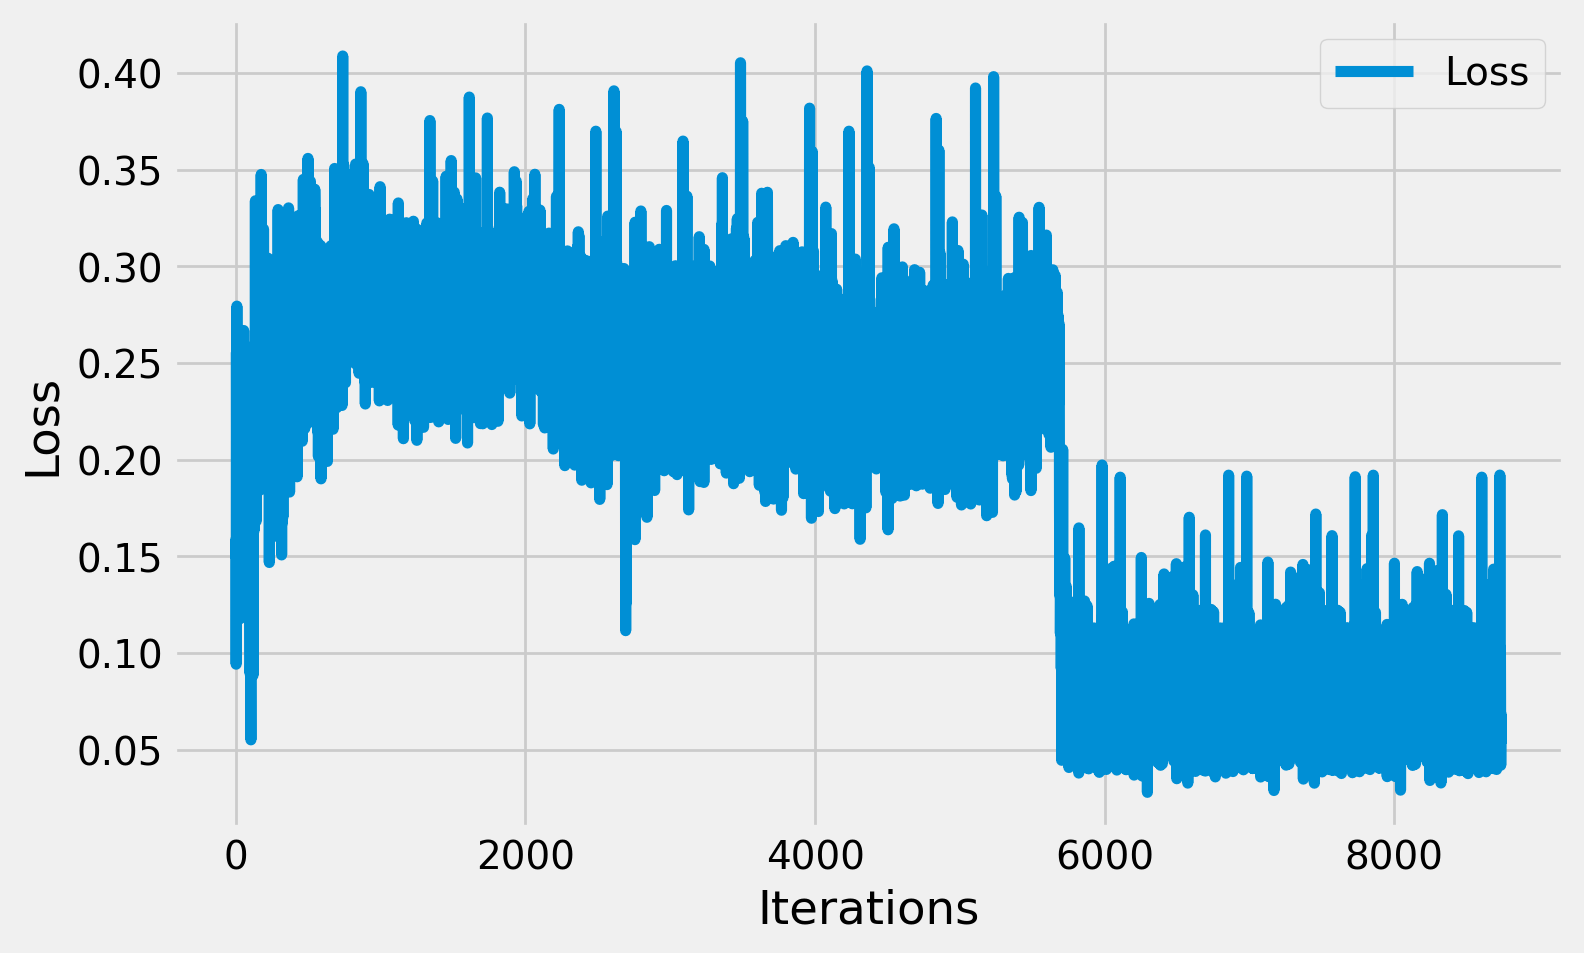

In [40]:
# Entraînement

epochs = 10
outputs = []
losses = []

device = torch.device("cpu")
model.to(device)

for epoch in range(epochs):
    for sequences in input_sequences:
        sequences = sequences.view(-1, 128).to(device)
        
        reconstructed = model(sequences)
        loss = loss_function(reconstructed, sequences)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, sequences, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


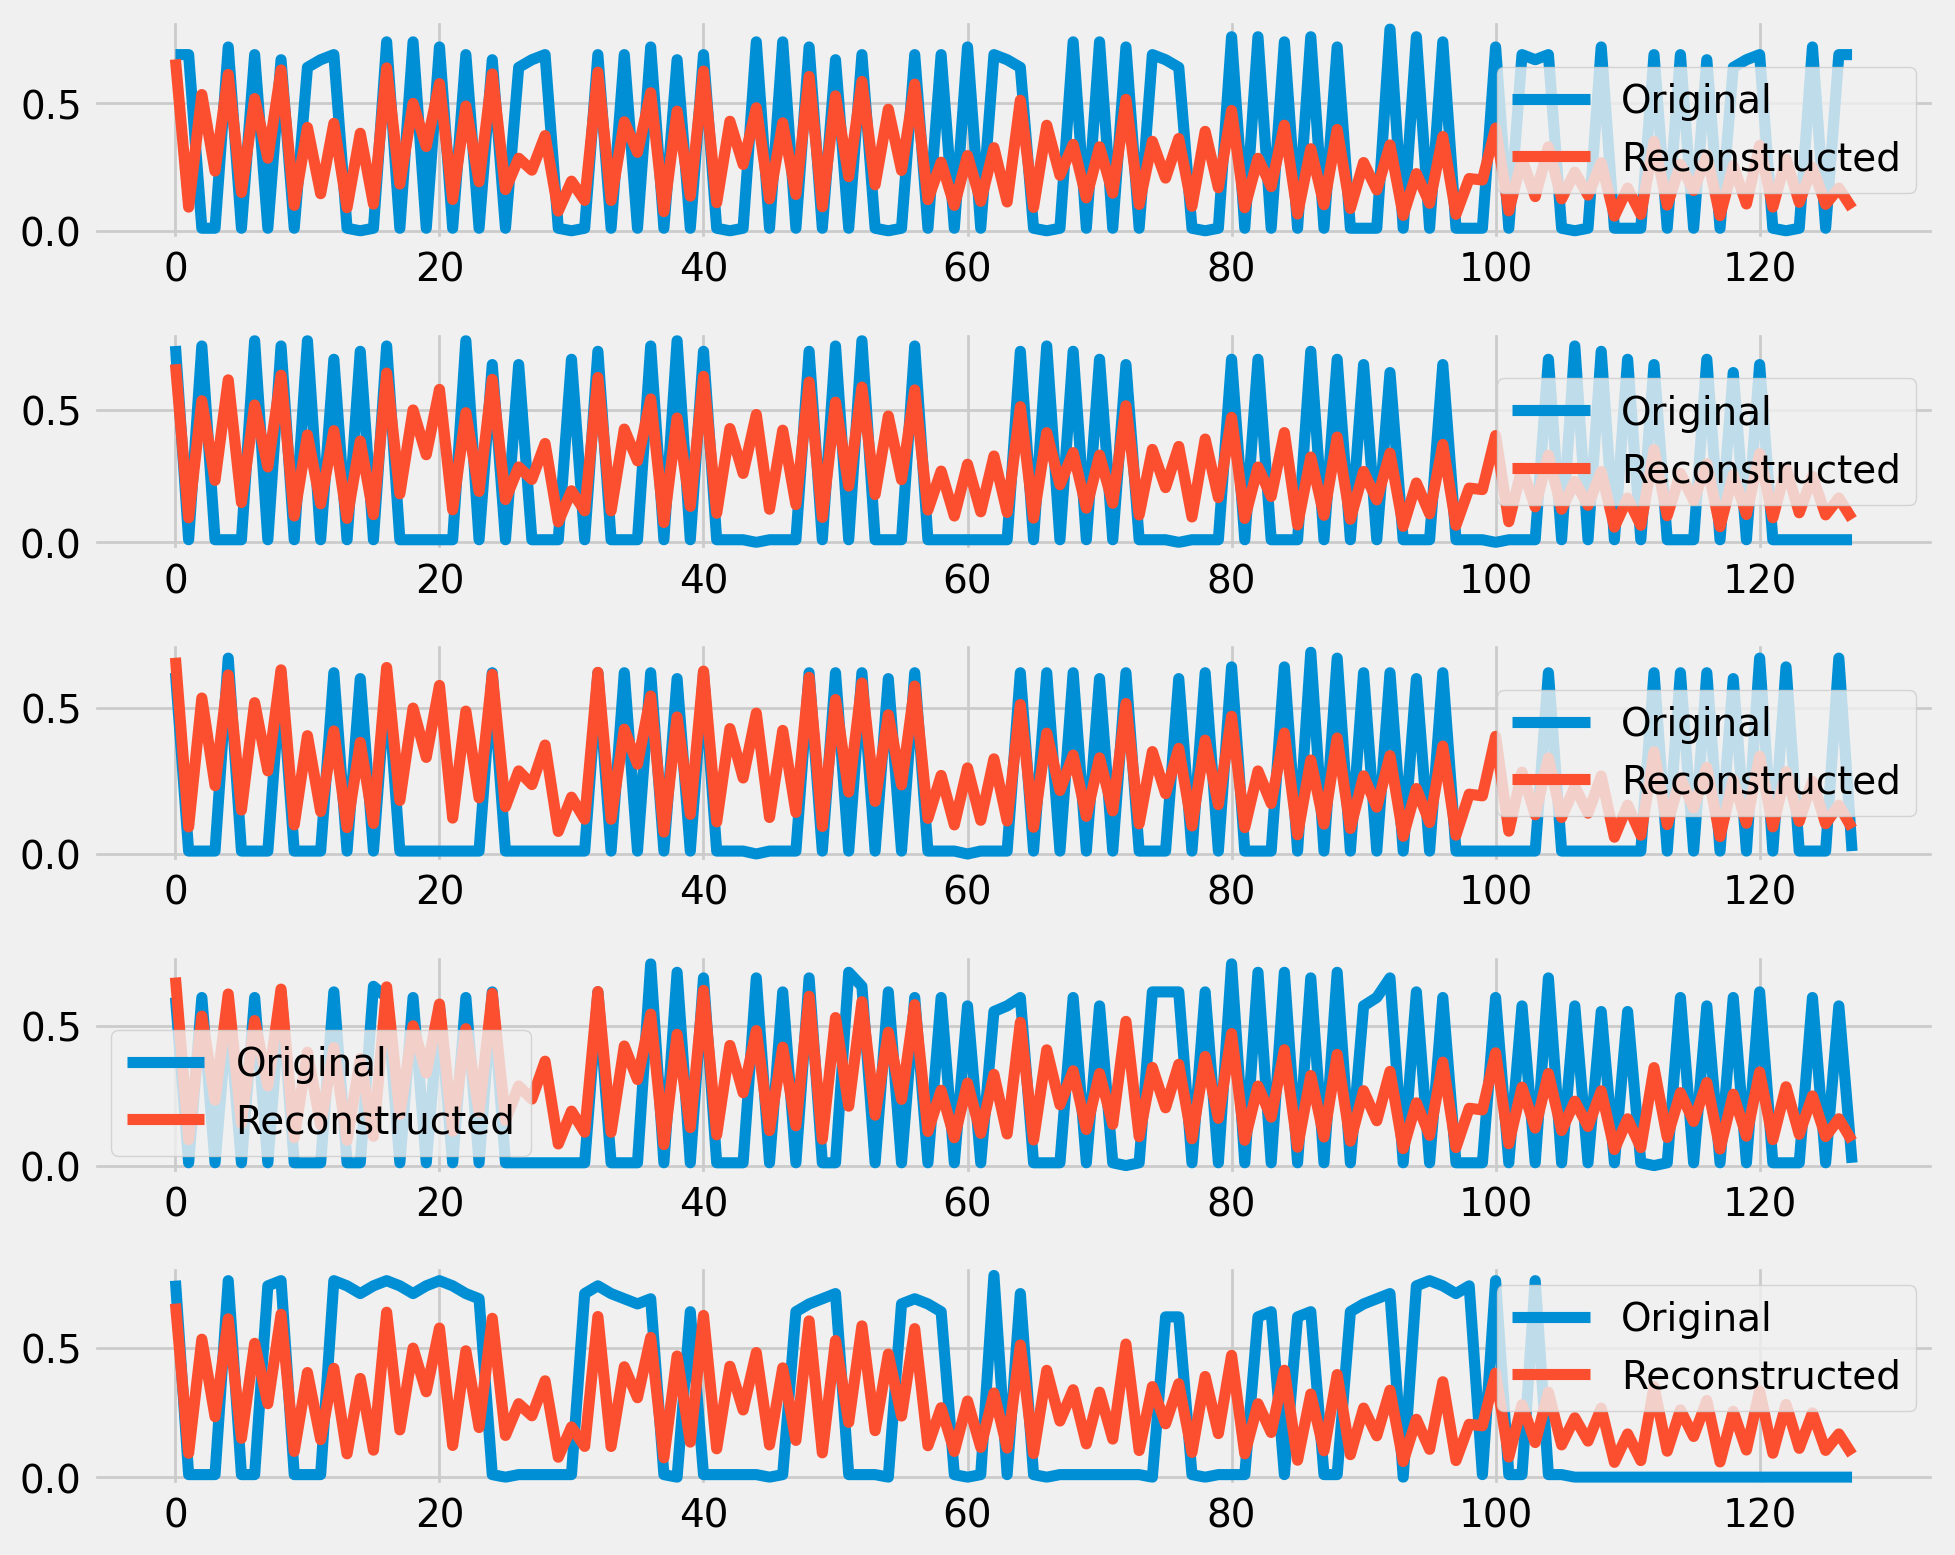

In [41]:
# Visualisation des résultats

def plot_reconstructed_sequence(model, sequences):
    reconstructed = model(sequences)
    sequences = sequences.view(-1, 128).detach().numpy()
    reconstructed = reconstructed.view(-1, 128).detach().numpy()
    
    plt.figure(figsize=(10, 8))
    for i in range(5):
        plt.subplot(5, 1, i+1)
        plt.plot(sequences[i], label='Original')
        plt.plot(reconstructed[i], label='Reconstructed')
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_reconstructed_sequence(model, input_sequences[:5])


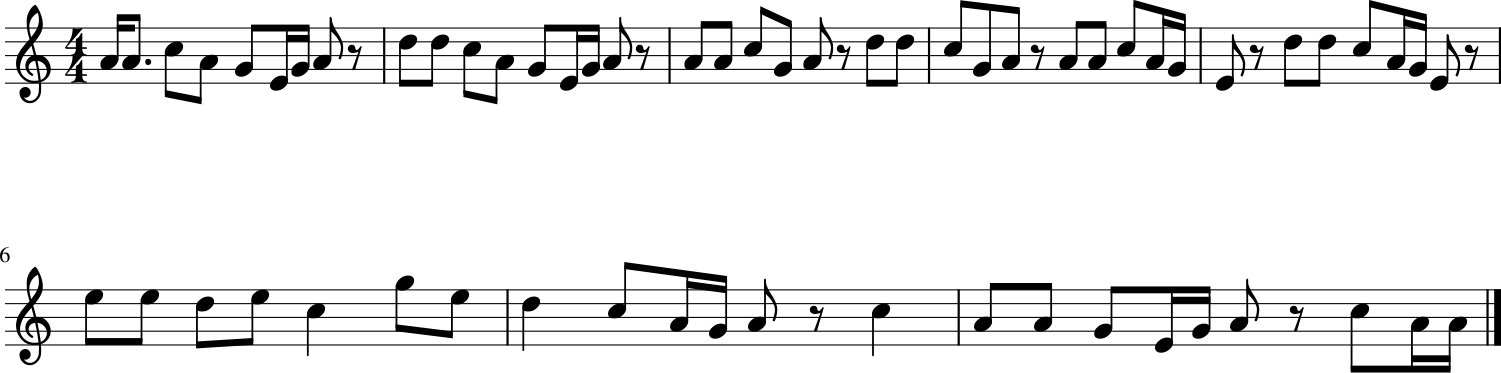

In [42]:
# Fonction pour afficher les sequences sous forme de notes 

def decode_song(encoded_song, time_step=0.25):
    from music21 import stream, note

    decoded_song = stream.Stream()
    i = 0

    while i < len(encoded_song):
        symbol = int(encoded_song[i] * 100)  # Remultiplier et arrondir


        # Déterminer la durée de l'événement
        duration = time_step
        while i + 1 < len(encoded_song) and encoded_song[i + 1] <= 0.5 and encoded_song[i + 1] != 0 :
            duration += time_step
            i += 1  # Avancer tant qu'on a des "1" (sustain)

        # Ajouter une note ou un silence
        if symbol == 0:
            m21_event = note.Rest(quarterLength=duration)
        else:
            m21_event = note.Note(midi=symbol, quarterLength=duration)

        decoded_song.append(m21_event)
        i += 1  # Passer à l'événement suivant
    
    # Supprimer les silences en trop
    for i in range(len(decoded_song) - 1, 0, -1):
        if decoded_song[i].isRest and decoded_song[i - 1].isRest:
            decoded_song.pop(i)

    return decoded_song


# Exemple
decoded_song = decode_song(input_sequences[0])
decoded_song.show()
        

Original


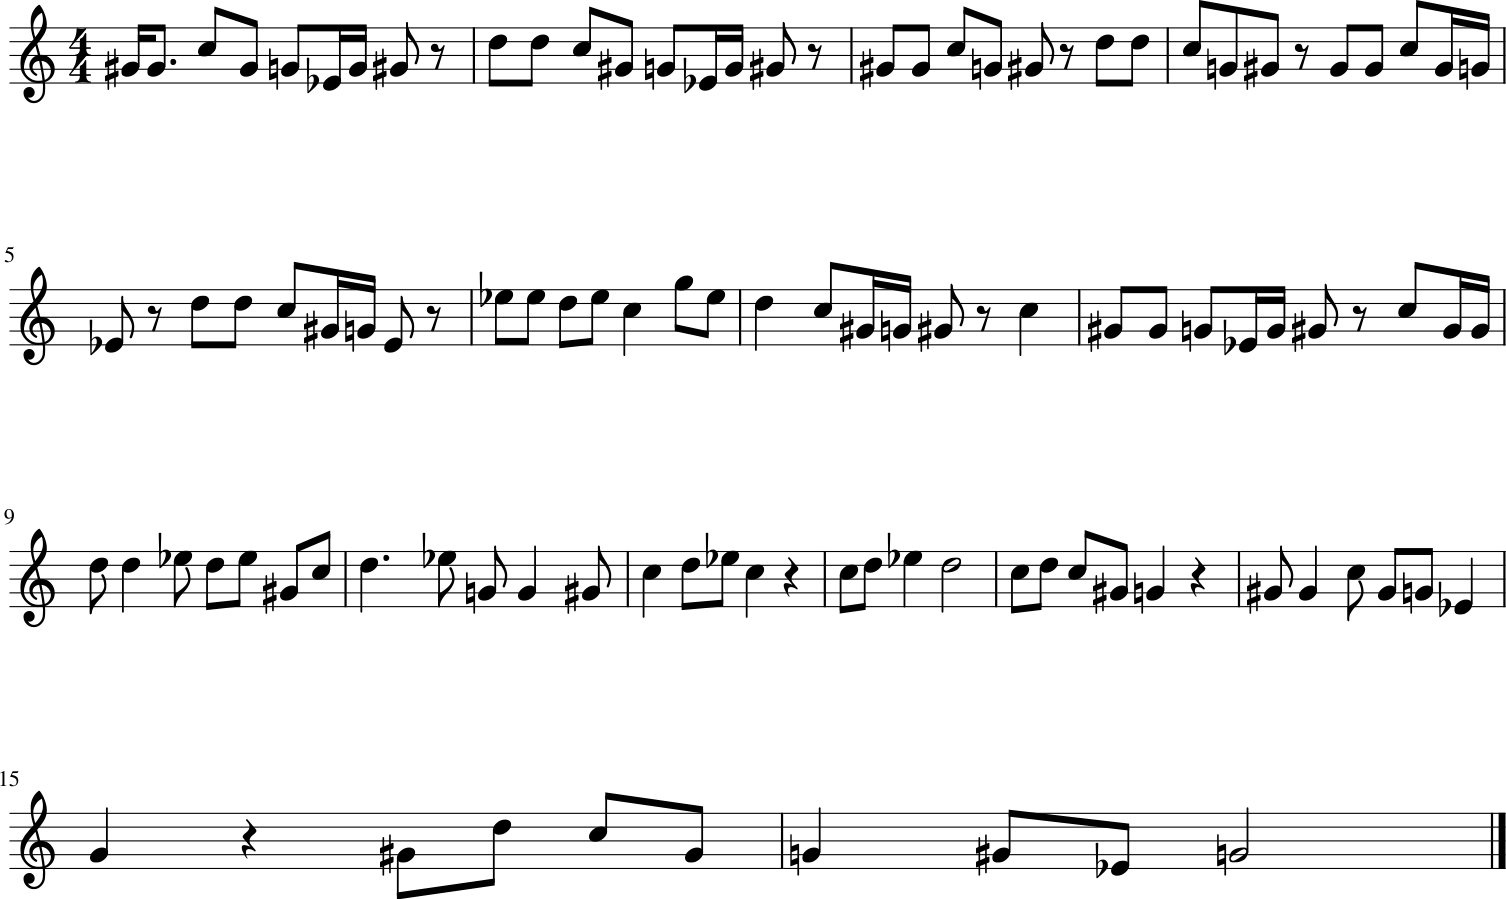

Reconstructed


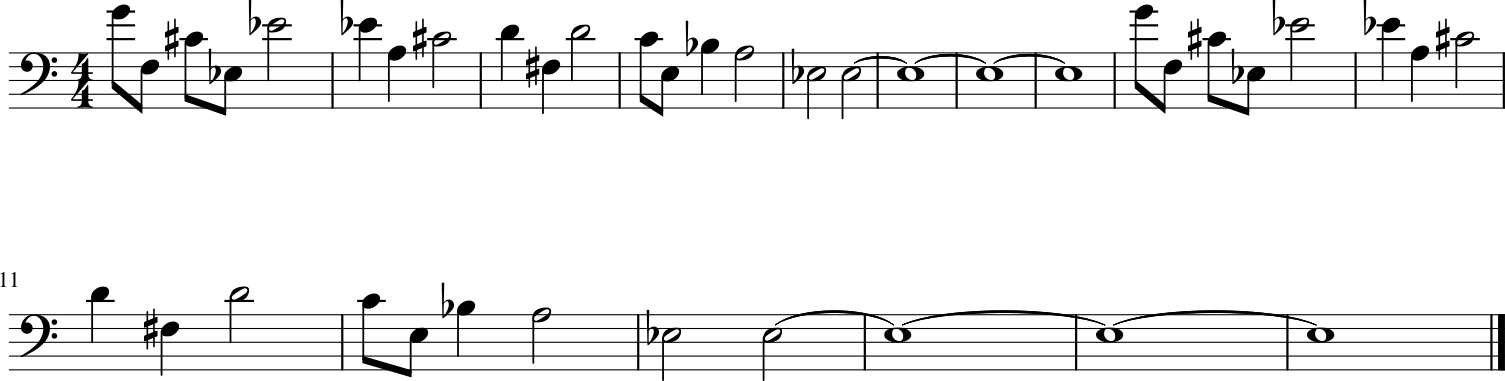

Original


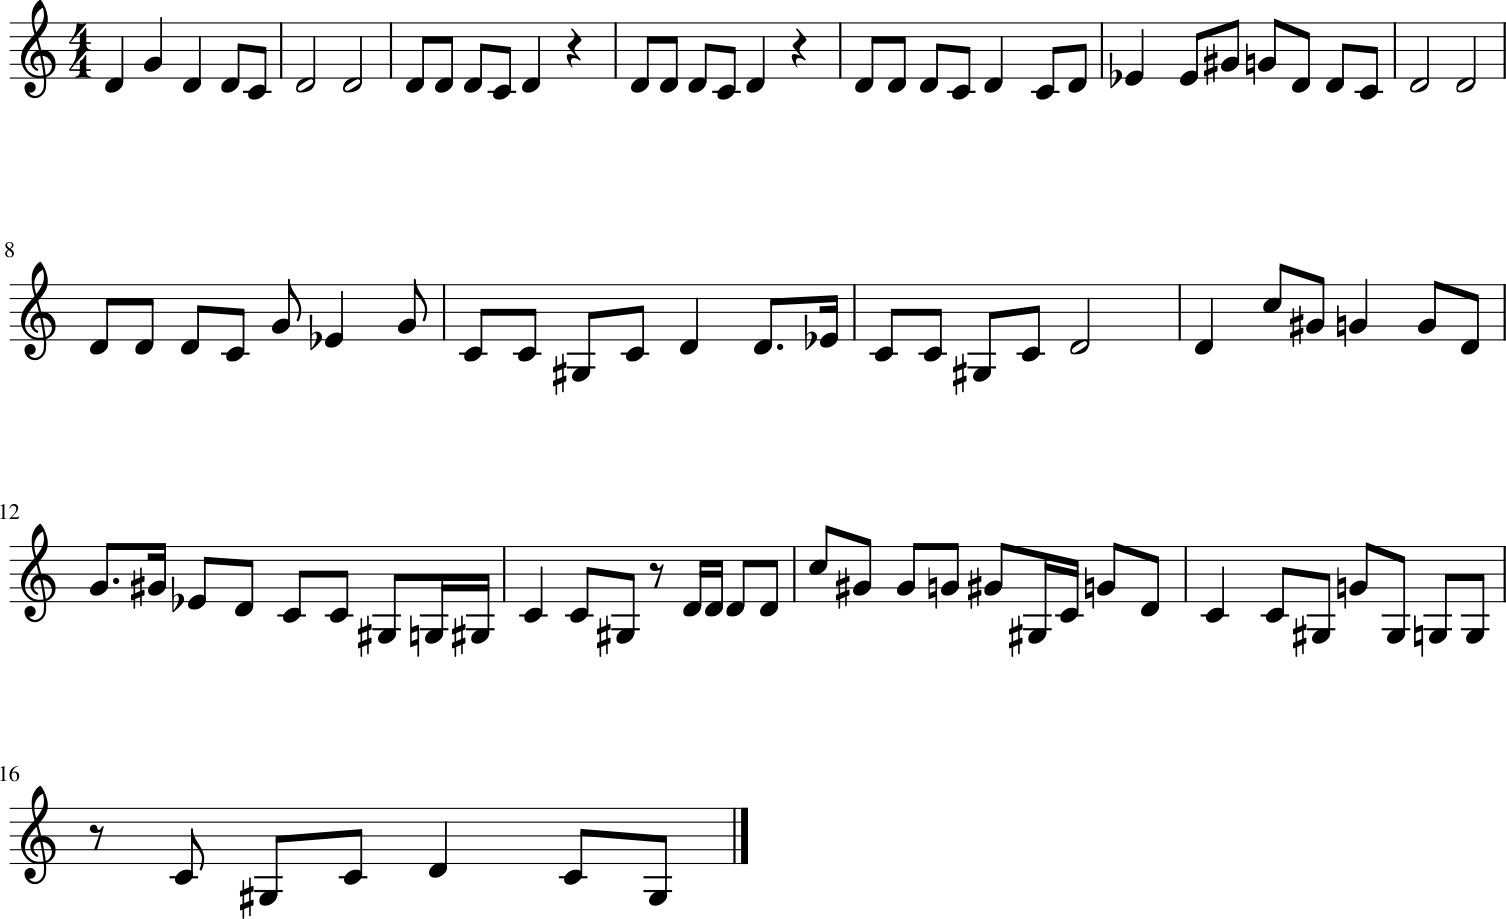

Reconstructed


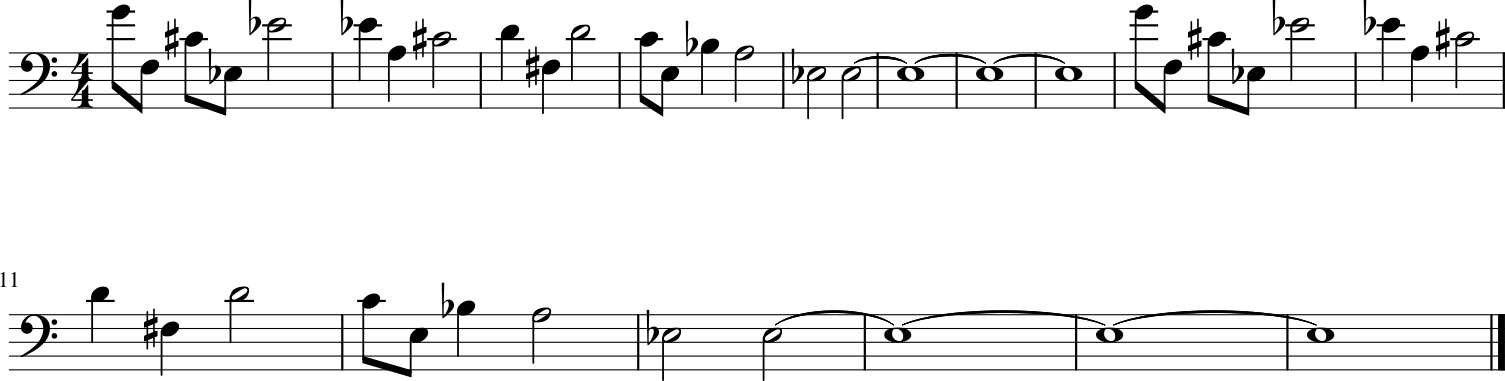

In [43]:
# Visualisation des résultats avec les notes

def plot_reconstructed_song(model, sequences, time_step=0.25, max_songs=2):
    reconstructed = model(sequences)
    sequences = sequences.view(-1, 256).detach().numpy()
    reconstructed = reconstructed.view(-1, 256).detach().numpy()

    for i in range(max_songs):
        original_song = decode_song(sequences[i], time_step)
        reconstructed_song = decode_song(reconstructed[i], time_step)

        print("Original")
        original_song.show()
        print("Reconstructed")
        reconstructed_song.show()

plot_reconstructed_song(model, input_sequences, max_songs=2)

Original song


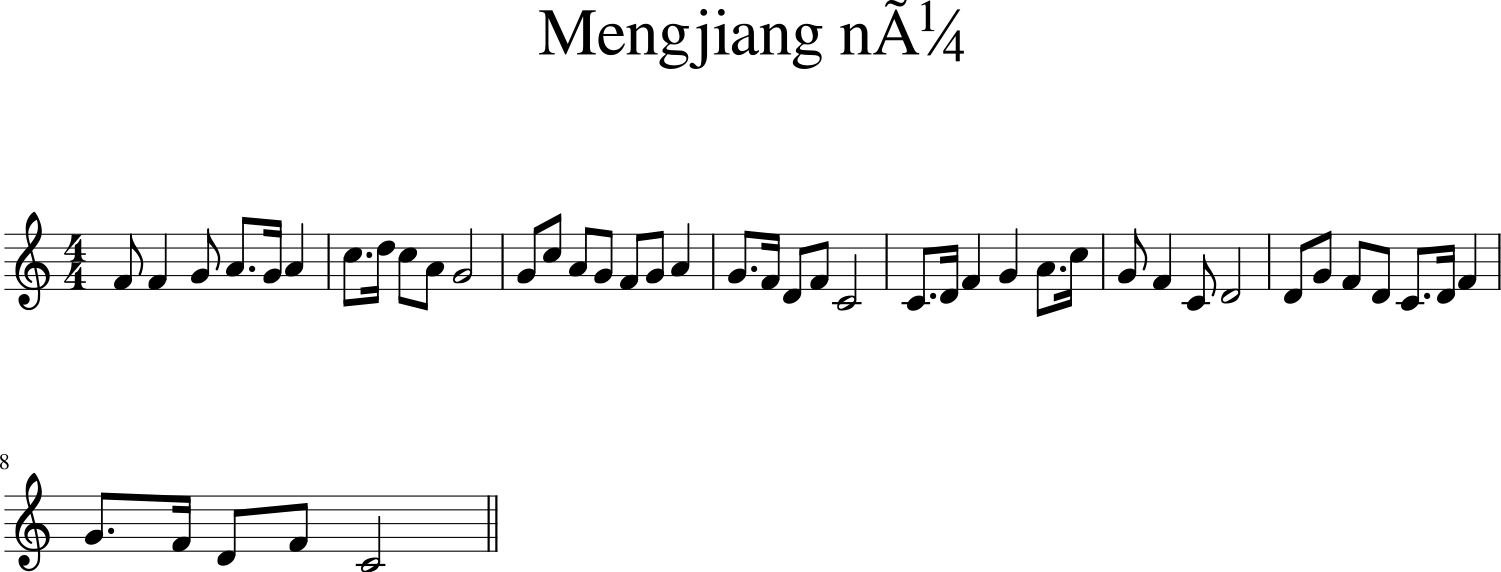

Generated song


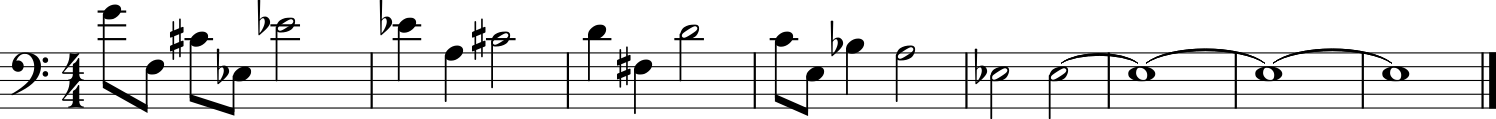

'ae1_0407.mid'

In [63]:
# Génération de musique

def generate_song(model, song, sequence_length=128, time_step=0.25):
    model.eval()
    input_song = create_input_sequence(song, sequence_length)
    if not input_song:
        print("Song has unacceptable duration. Can't generate song.")
        return None
    input_song = torch.tensor(input_song, dtype=torch.float32).view(1, -1)
    input_song = input_song.to(device)

    # generate song
    new_song = model(input_song)
    new_song = new_song.view(-1, 128).detach().numpy()
    new_song = new_song[0]

    # decode song
    new_song = decode_song(new_song, time_step)
    return new_song

# Exemple
song_path = "data/han/han0407.krn"
song = m21.converter.parse(song_path)
print("Original song")
song.show()
song.show("midi")

generated_song = generate_song(model, song)
print("Generated song")
generated_song.show()
generated_song.show("midi")
generated_song.write("midi", "ae1_0407.mid")



## VAE vanille 
Modèle créé à partir du modèle d'autoencoder précédent avec la même préparation des données

In [54]:
import torch
from torch import nn, optim

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(18, 9)
        self.fc_logvar = nn.Linear(18, 9)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # bruit gaussien
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar

def vae_loss(reconstructed, original, mu, logvar):
    reconstruction_loss = nn.functional.mse_loss(reconstructed, original, reduction='sum')
    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_div

# Initialisation du modèle et des hyperparamètres
model_vae = VAE()
optimizer = optim.Adam(model_vae.parameters(), lr=0.0001, weight_decay=1e-5)


Epoch 1/20, Loss: 6.759548
Epoch 2/20, Loss: 6.679450
Epoch 3/20, Loss: 6.130944
Epoch 4/20, Loss: 6.152315
Epoch 5/20, Loss: 6.698268
Epoch 6/20, Loss: 6.271441
Epoch 7/20, Loss: 6.273901
Epoch 8/20, Loss: 6.257823
Epoch 9/20, Loss: 6.373527
Epoch 10/20, Loss: 6.522851
Epoch 11/20, Loss: 6.156287
Epoch 12/20, Loss: 6.244071
Epoch 13/20, Loss: 6.495395
Epoch 14/20, Loss: 6.314327
Epoch 15/20, Loss: 6.940214
Epoch 16/20, Loss: 6.205518
Epoch 17/20, Loss: 6.432604
Epoch 18/20, Loss: 6.389891
Epoch 19/20, Loss: 6.427300
Epoch 20/20, Loss: 6.907916


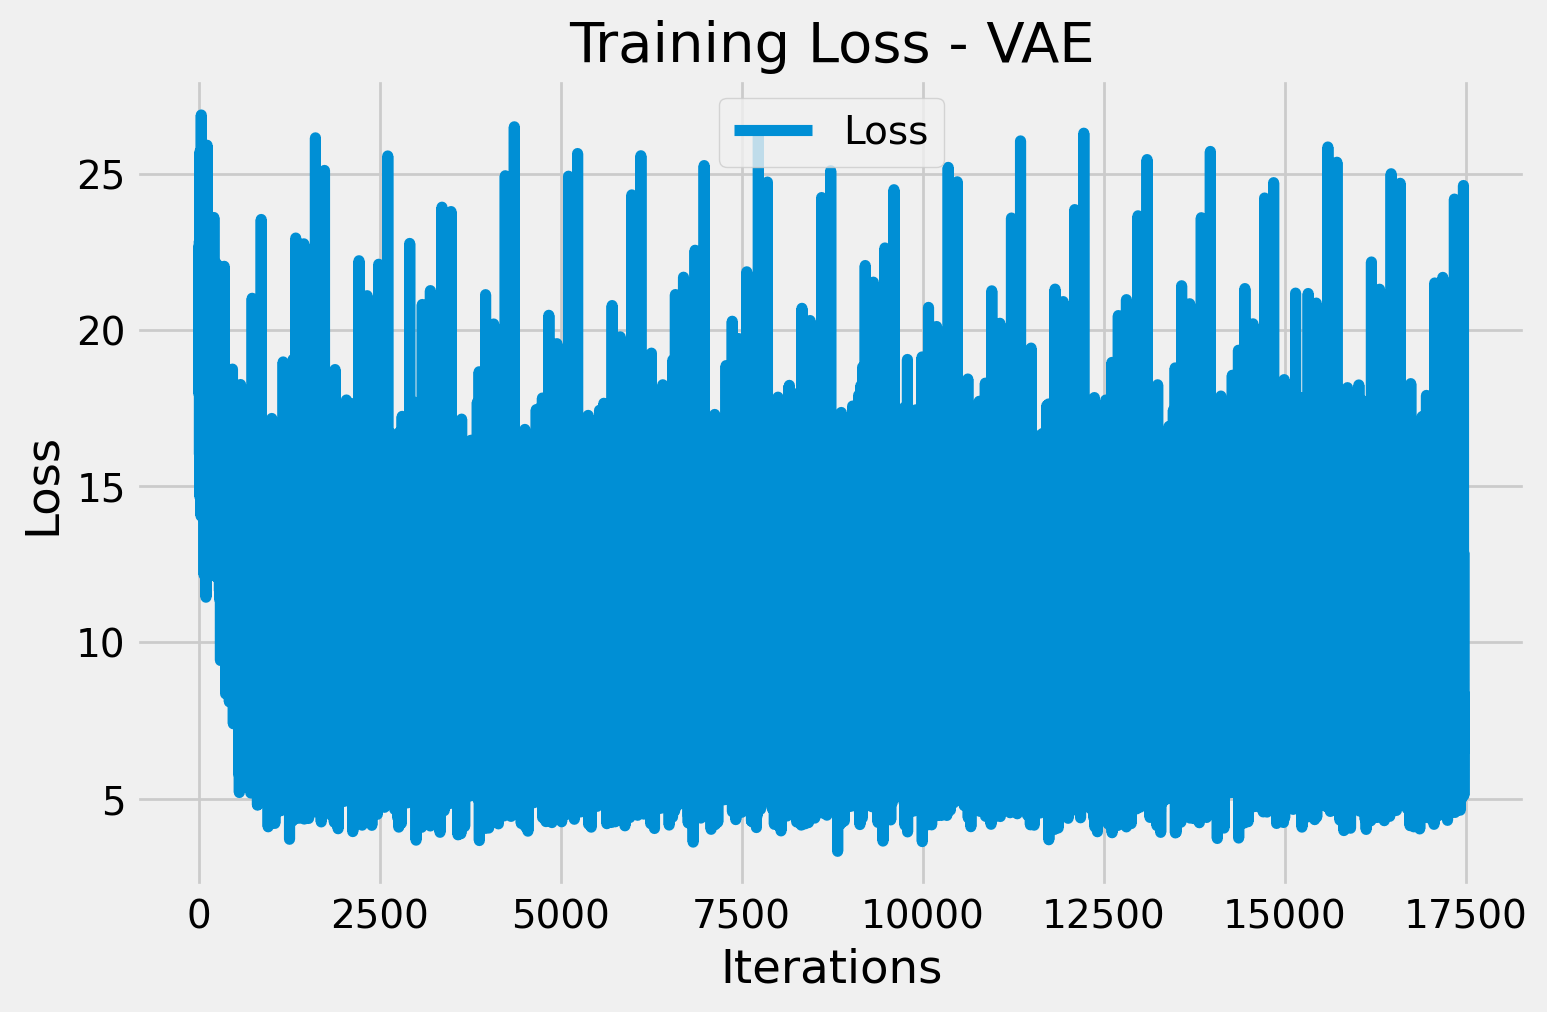

In [55]:
epochs = 20
outputs = []
losses = []

device = torch.device("cpu")  # ou "cuda" si tu as un GPU
model_vae.to(device)

for epoch in range(epochs):
    for sequences in input_sequences:
        sequences = sequences.view(-1, 128).to(device)

        reconstructed, mu, logvar = model_vae(sequences)
        loss = vae_loss(reconstructed, sequences, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    outputs.append((epoch, sequences.detach(), reconstructed.detach()))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

# Affichage de la courbe des pertes
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title("Training Loss - VAE")
plt.show()


Original


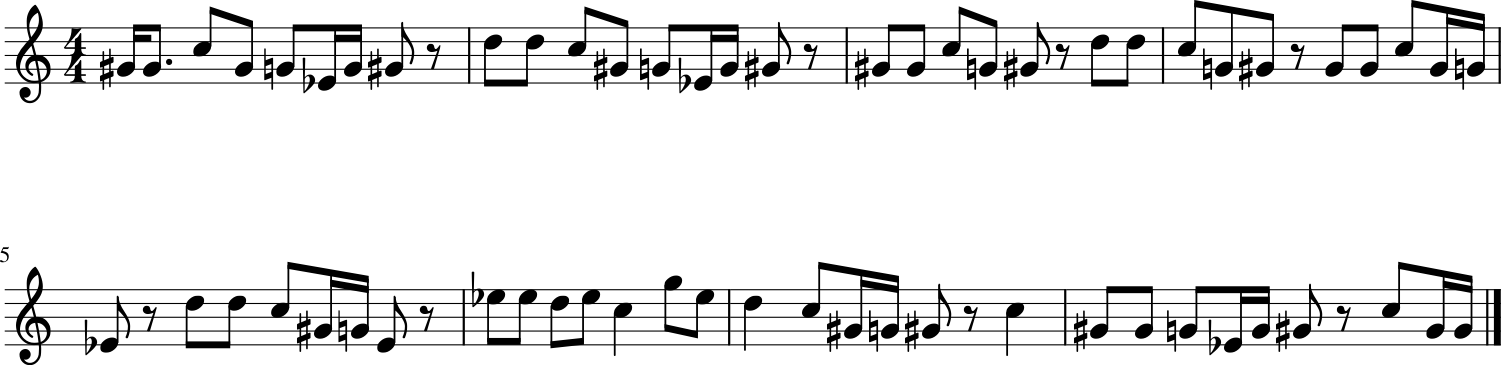

Reconstructed


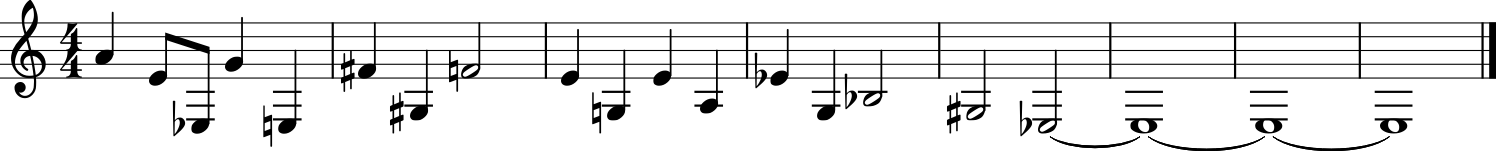

Original


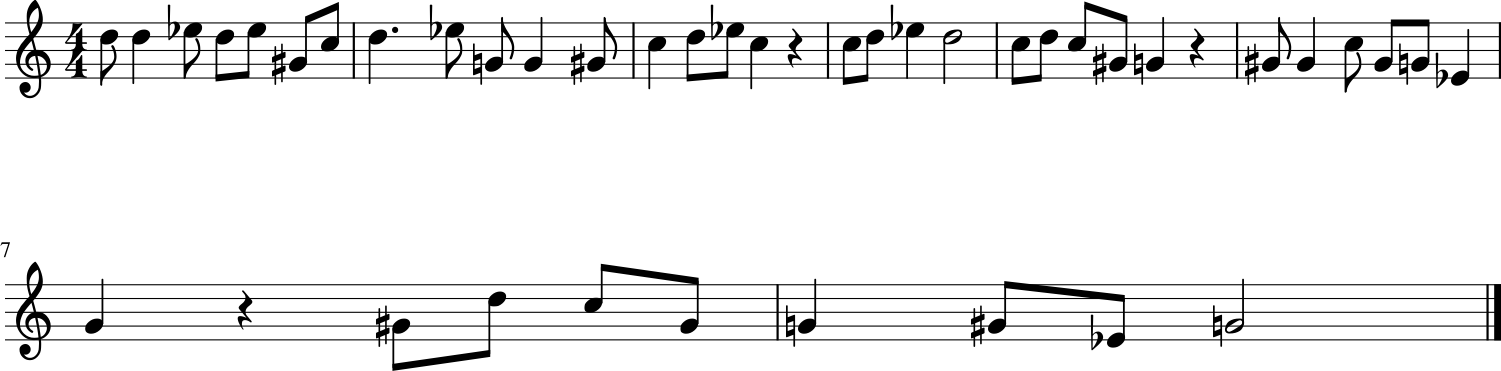

Reconstructed


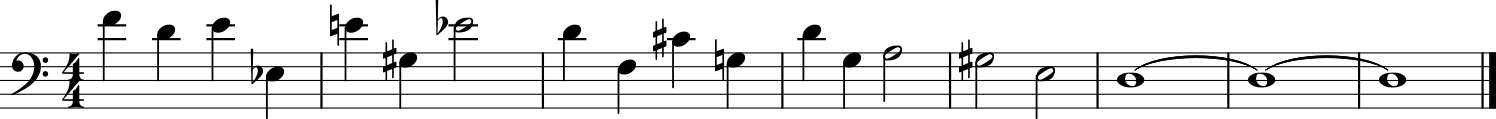

In [56]:
def plot_reconstructed_song(model, sequences, time_step=0.25, max_songs=2):
    model.eval()
    with torch.no_grad():
        reconstructed, _, _ = model(sequences)

    sequences = sequences.view(-1, 128).detach().numpy()
    reconstructed = reconstructed.view(-1, 128).detach().numpy()

    for i in range(min(max_songs, len(sequences))):
        original_song = decode_song(sequences[i], time_step)
        reconstructed_song = decode_song(reconstructed[i], time_step)
        print("Original")
        original_song.show()
        print("Reconstructed")
        reconstructed_song.show()

plot_reconstructed_song(model_vae, input_sequences)

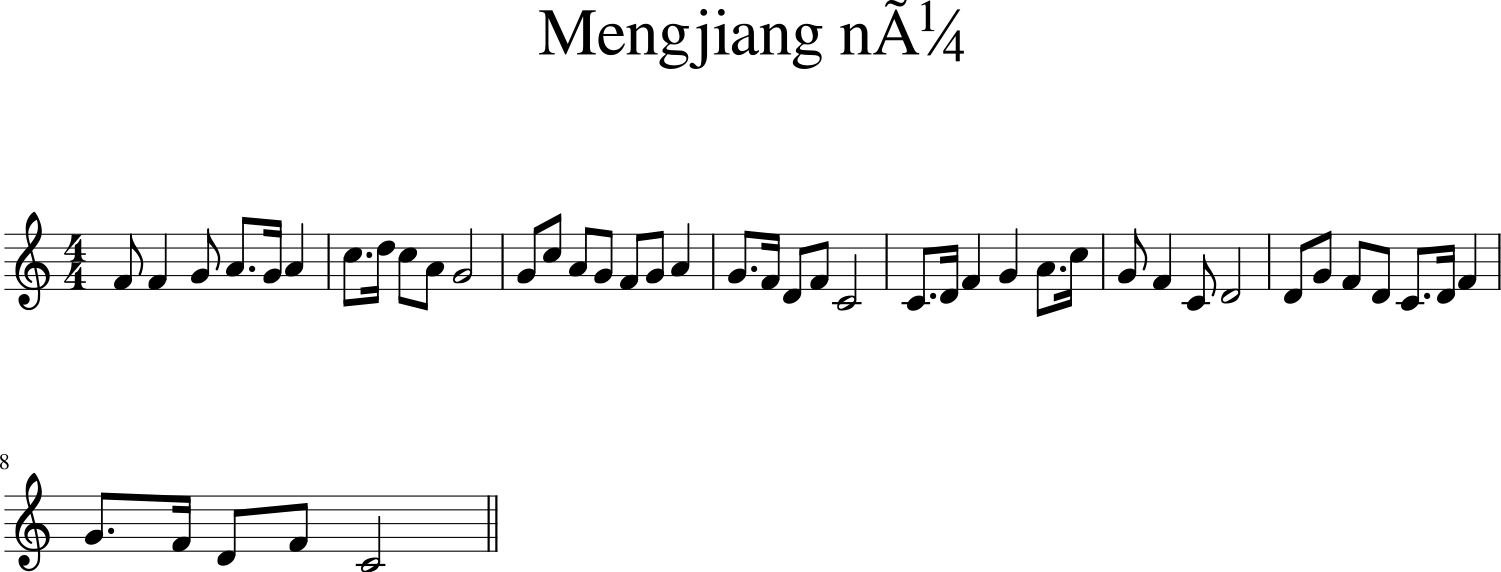

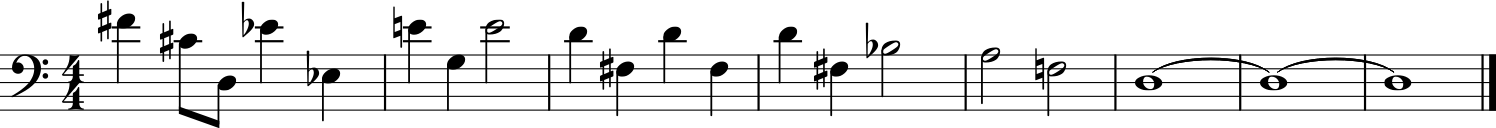

'vae1_0407.mid'

In [62]:
# Génération de musique

def generate_song(model, song, sequence_length=128, time_step=0.25):
    model.eval()
    input_song = create_input_sequence(song, sequence_length)
    if not input_song:
        print("Song has unacceptable duration. Can't generate song.")
        return None

    input_song = torch.tensor(input_song, dtype=torch.float32).view(1, -1).to(device)

    # Reconstruction via VAE (on ignore mu et logvar ici)
    with torch.no_grad():
        reconstructed, _, _ = model(input_song)
    
    reconstructed = reconstructed.view(-1, 128).cpu().numpy()[0]

    # Decode the reconstructed song
    new_song = decode_song(reconstructed, time_step)
    return new_song


# Exemple
song_path = "data/han/han0407.krn"
song = m21.converter.parse(song_path)
song.show()
song.show("midi")

generated_song = generate_song(model_vae, song)
generated_song.show()
generated_song.show("midi")
generated_song.write("midi", "vae1_0407.mid")

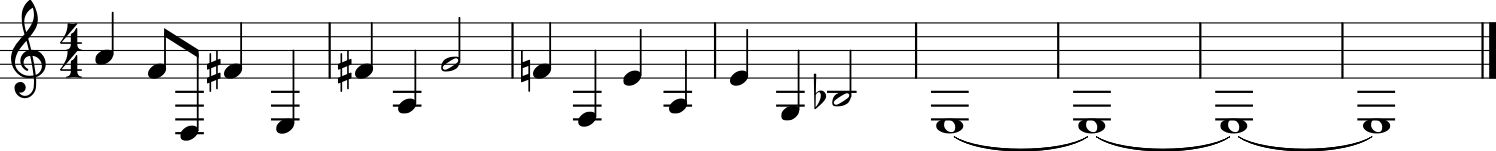

In [60]:
def generate_random_song(model, time_step=0.25):
    model.eval()
    with torch.no_grad():
        # Tirage aléatoire dans l’espace latent (taille 9 dans ton cas)
        z = torch.randn(1, 9).to(device)
        reconstructed = model.decoder(z)
        reconstructed = reconstructed.view(-1, 128).cpu().numpy()[0]

        new_song = decode_song(reconstructed, time_step)
        return new_song

random_song = generate_random_song(model_vae)
random_song.show()
random_song.show("midi")
